In [1]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.


In [25]:
# biosignalsnotebooks Python package with useful functions that support and complement the available Notebooks
import biosignalsnotebooks as bsnb

# Function used for creating a numpy array, where a mathematical operation can be applied to each entry 
# in an easy and automatic way. On the other side, linspace, here will be used for generation of a time-axis.
from numpy import array, linspace
import numpy as np
import matplotlib.pyplot as plt
import pywt
# Numpy package is dedicated to simplify the work (operations between) with arrays/lists
from numpy import cumsum, concatenate, zeros, linspace, average, power, absolute, mean, std, max, array, diff, where

# Scientific packages
from scipy.signal import butter, lfilter
from scipy.stats import linregress


In [22]:
# Load of data
data, header = bsnb.load("C:/Users/Equipo/OneDrive/Escritorio/Introduccion_a_señales_biomedicas/Github/inb_2024_gh12/Documentación/EMG/Lectura_antebrazo_supinación_EMG.txt", get_header=True)

ch = "CH1" # Channel
sr = 1000 # Sampling rate
resolution = 10 # Resolution (number of available bits)


In [4]:
signalraw = data[ch]
vcc = 3300 # mV
gain = 1001
signal_mv = (((array(signalraw) / 2**resolution) - 0.5) * vcc) / gain

time = bsnb.generate_time(signal_mv, sr)


In [5]:
# Cargar la señal EMG
emg_signal = signal_mv

# Aplicar la DWT con filtro db2 al nivel de descomposición 4
coefficients = pywt.wavedec(emg_signal, 'db2', level=4)

# Estimar la desviación estándar del ruido
sigma = np.median(np.abs(coefficients[1])) / 0.6745

# Calcular el umbral universal
threshold = sigma * np.sqrt(2 * np.log(len(emg_signal)))

# Realizar la umbralización suave
coefficients_filtered = [pywt.threshold(c, threshold, mode='soft') for c in coefficients]

# Reconstruir la señal filtrada
emg_filtered_db2 = pywt.waverec(coefficients_filtered, 'db2')

# Mostrar la señal filtrada
emg_filtered_db2

array([-0.00755496, -0.00751239, -0.00593228, ...,  0.06832811,
       -0.02083167, -0.07401488])

In [6]:
# Cargar la señal EMG
emg_signal = signal_mv
# Aplicar la DWT con filtro db4 al nivel de descomposición 4
coefficients = pywt.wavedec(emg_signal, 'db4', level=4)

# Estimar la desviación estándar del ruido
sigma = np.median(np.abs(coefficients[1])) / 0.6745

# Calcular el umbral universal
threshold = sigma * np.sqrt(2 * np.log(len(emg_signal)))

# Realizar la umbralización suave en cada conjunto de coeficientes
coefficients_filtered = [pywt.threshold(c, threshold, mode='soft') for c in coefficients]

# Reconstruir la señal filtrada
emg_filtered_db4 = pywt.waverec(coefficients_filtered, 'db4')

# Mostrar la señal filtrada
emg_filtered_db4


array([ 0.        ,  0.        ,  0.        , ...,  0.02492123,
       -0.00457085, -0.10098035])

In [7]:
# Cargar la señal EMG
emg_signal = signal_mv

# Aplicar la DWT con filtro db6 al nivel de descomposición 4
coefficients = pywt.wavedec(emg_signal, 'db6', level=4)

# Estimar la desviación estándar del ruido
sigma = np.median(np.abs(coefficients[1])) / 0.6745

# Calcular el umbral universal
threshold = sigma * np.sqrt(2 * np.log(len(emg_signal)))

# Realizar la umbralización suave en cada conjunto de coeficientes excepto el primero (cA)
coefficients_filtered = [coefficients[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coefficients[1:]]

# Reconstruir la señal filtrada
emg_filtered_db6 = pywt.waverec(coefficients_filtered, 'db6')

In [8]:
def snr(signal, filtered_signal):
    noise = signal - filtered_signal
    return 10 * np.log10(np.sum(signal**2) / np.sum(noise**2))

def psnr(signal, filtered_signal):
    mse = np.mean((signal - filtered_signal)**2)
    return 20 * np.log10(np.max(signal) / np.sqrt(mse))

def rmse(signal, filtered_signal):
    return np.sqrt(np.mean((signal - filtered_signal)**2))

def compare_filtering_methods(original_signal, filtered_signal1, filtered_signal2, filtered_signal3):
    snr_results = [snr(original_signal, filtered_signal) for filtered_signal in [filtered_signal1, filtered_signal2, filtered_signal3]]
    psnr_results = [psnr(original_signal, filtered_signal) for filtered_signal in [filtered_signal1, filtered_signal2, filtered_signal3]]
    rmse_results = [rmse(original_signal, filtered_signal) for filtered_signal in [filtered_signal1, filtered_signal2, filtered_signal3]]

    best_snr_index = np.argmax(snr_results)
    best_psnr_index = np.argmax(psnr_results)
    best_rmse_index = np.argmin(rmse_results)

    if best_snr_index == best_psnr_index == best_rmse_index:
        best_method = best_snr_index + 1
    else:
        best_method = np.argmax([snr_results[best_snr_index], psnr_results[best_psnr_index], -rmse_results[best_rmse_index]]) + 1

    print(f"SNR Results: {snr_results}")
    print(f"PSNR Results: {psnr_results}")
    print(f"RMSE Results: {rmse_results}")
    print(f"Best Filtering Method: Signal {best_method}")

# Load the original EMG signal and the three filtered signals
original_signal = signal_mv
filtered_signal1 = emg_filtered_db2
filtered_signal2 = emg_filtered_db4
filtered_signal3 = emg_filtered_db6

# Compare the filtering methods
compare_filtering_methods(original_signal, filtered_signal1, filtered_signal2, filtered_signal3)


SNR Results: [3.0840620656185314, 3.066229134856453, 4.049368884814205]
PSNR Results: [25.56738496699729, 25.549552036235212, 26.532691786192967]
RMSE Results: [0.029339773751699348, 0.02940007288591361, 0.02625375448539476]
Best Filtering Method: Signal 3


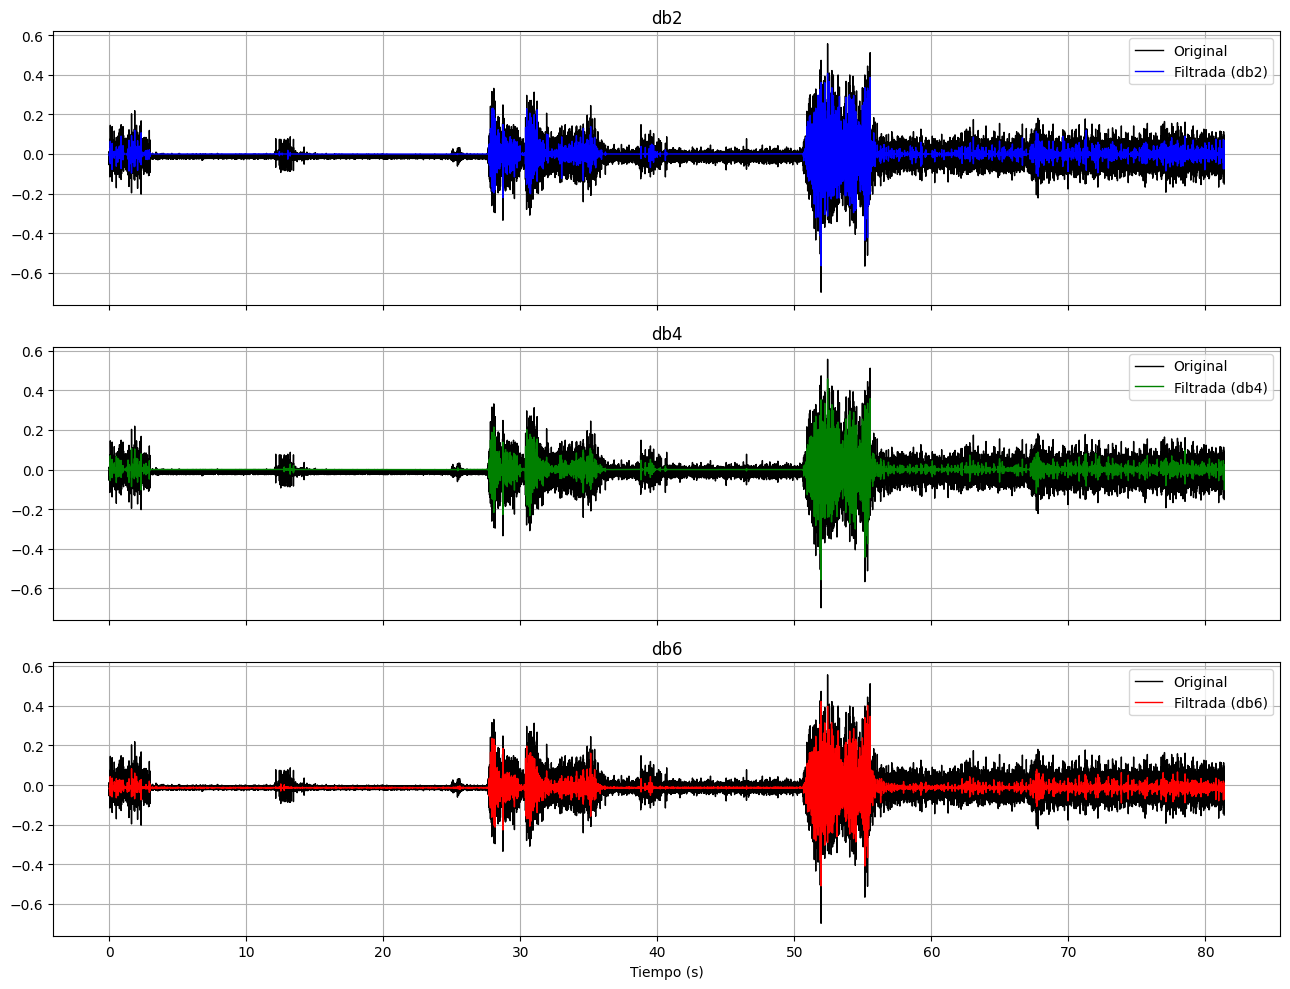

In [19]:
plt.figure(figsize=(13, 10))

# Primer subplot (db2)
ax1 = plt.subplot(3, 1, 1)
ax1.plot(time, signal_mv, lw=1, color='black', label='Original')
ax1.plot(time, emg_filtered_db2, lw=1, color='blue', label='Filtrada (db2)')
ax1.set_title("db2")
ax1.grid(True)
ax1.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

# Segundo subplot (db4)
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(time, signal_mv, lw=1, color='black', label='Original')
ax2.plot(time, emg_filtered_db4, lw=1, color='green', label='Filtrada (db4)')
ax2.set_title("db4")
ax2.grid(True)
ax2.legend()
plt.setp(ax2.get_xticklabels(), visible=False)

# Tercer subplot (db6)
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(time, signal_mv, lw=1, color='black', label='Original')
ax3.plot(time, emg_filtered_db6, lw=1, color='red', label='Filtrada (db6)')
ax3.set_title("db6")
ax3.grid(True)
ax3.legend()
ax3.set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()

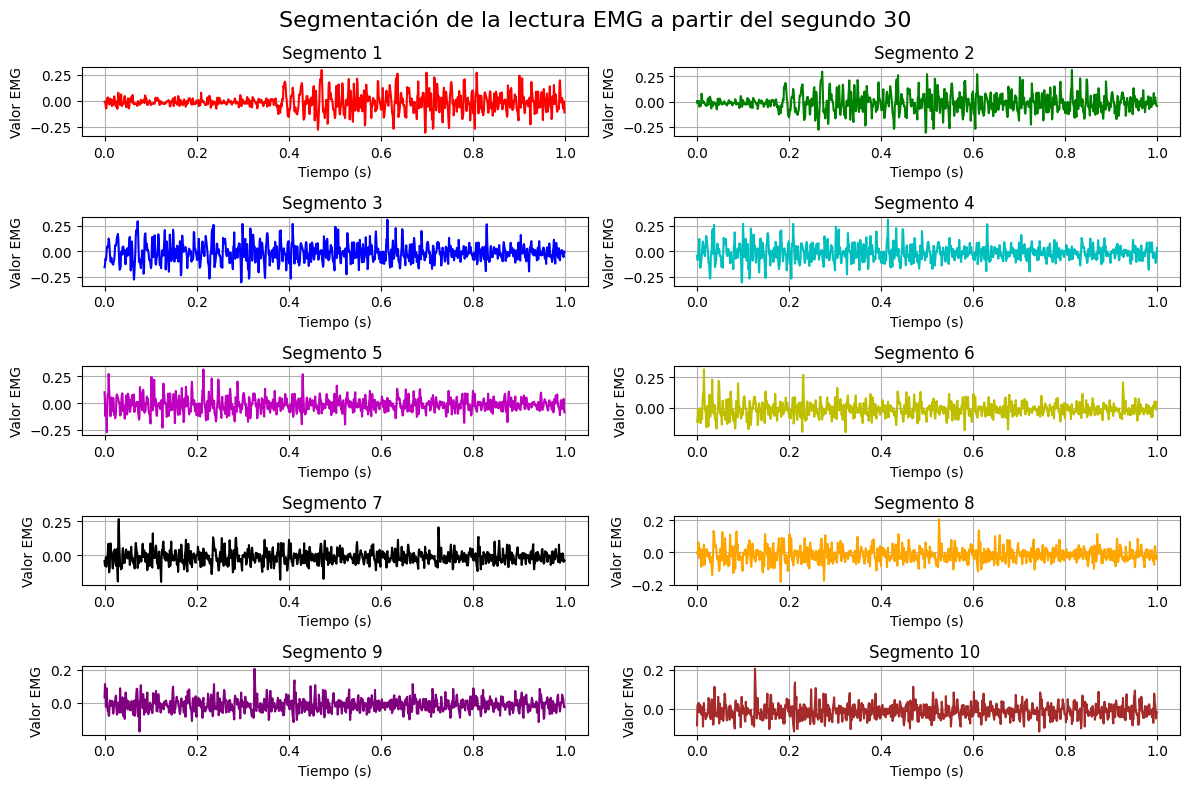

In [14]:
señal_filtrada=emg_filtered_db6
# Definir la duración de la ventana y el aumento en segundos
window_duration = 1.000  # 1000 ms
window_shift = 0.200     # 200 ms

# Convertir la duración de la ventana y el aumento a muestras
sampling_rate = len(señal_filtrada) / time[-1]  # Frecuencia de muestreo en muestras por segundo
window_size = int(window_duration * sampling_rate)
shift_size = int(window_shift * sampling_rate)

spot=30
# Encontrar el índice a partir del cual la señal comienza desde el segundo 30
start_index = np.searchsorted(time, spot)

# Segmentar la señal en ventanas a partir del segundo 9
segments = []
for start in range(start_index, len(signal_mv) - window_size + 1, shift_size):
    end = start + window_size
    segment = signal_mv[start:end]
    segments.append(segment)

# Convertir la lista de segmentos a un array numpy
segments = np.array(segments)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

# Graficar algunos segmentos para ver los resultados
plt.figure(figsize=(12, 8))
plt.suptitle("Segmentación de la lectura EMG a partir del segundo 30", fontsize=16)

for i in range(10):  # Graficar los primeros x segmentos
    plt.subplot(5, 2, i + 1)
    plt.plot(np.arange(window_size) / sampling_rate, segments[i],color=colors[i])
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Valor EMG')
    plt.title(f'Segmento {i+1} ')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:

def MAV(segment):
    return np.mean(np.abs(segment))

def MAV_slope(segment):
    mav_values = [np.mean(np.abs(segment[i:i+2])) for i in range(len(segment)-1)]
    return np.mean(np.abs(np.diff(mav_values)))

def SSC(segment):
    return np.sum(np.diff(np.sign(np.diff(segment))) != 0)

def WL(segment):
    return np.sum(np.abs(np.diff(segment)))

def ZC(segment, threshold=0):
    zero_crossings = np.where(np.diff(np.sign(segment)))[0]
    return np.sum(np.abs(segment[zero_crossings]) > threshold)

# Extraer características de los primeros 10 segmentos
features = []
for i in range(10):
    segment = segments[i]
    features.append({
        'MAV': MAV(segment),
        'MAV_slope': MAV_slope(segment),
        'SSC': SSC(segment),
        'WL': WL(segment),
        'ZC': ZC(segment)
    })

# Mostrar las características de los primeros 10 segmentos
#for i, feature_set in enumerate(features, start=1):
#    print(f"Segmento {i}:")
#    for feature_name, value in feature_set.items():
#        print(f"  {feature_name}: {value}")
#    print()


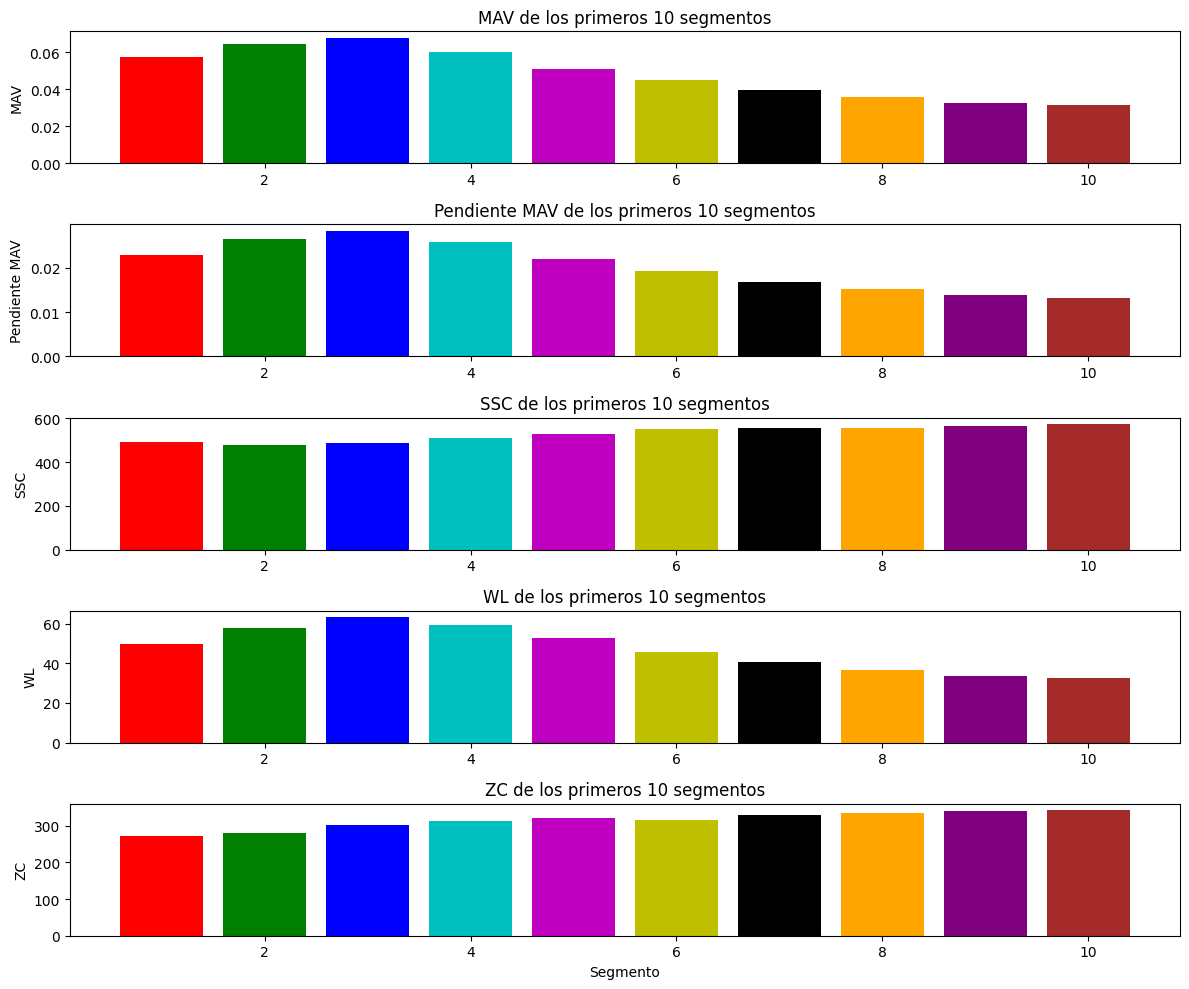

In [21]:

# Lista de colores
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

# Graficar características
fig, axs = plt.subplots(5, 1, figsize=(12, 10))

mav_values = [f['MAV'] for f in features]
mav_slope_values = [f['MAV_slope'] for f in features]
ssc_values = [f['SSC'] for f in features]
wl_values = [f['WL'] for f in features]
zc_values = [f['ZC'] for f in features]

axs[0].bar(range(1, 11), mav_values, color=colors)
axs[0].set_title('MAV de los primeros 10 segmentos')
axs[0].set_ylabel('MAV')

axs[1].bar(range(1, 11), mav_slope_values, color=colors)
axs[1].set_title('Pendiente MAV de los primeros 10 segmentos')
axs[1].set_ylabel('Pendiente MAV')

axs[2].bar(range(1, 11), ssc_values, color=colors)
axs[2].set_title('SSC de los primeros 10 segmentos')
axs[2].set_ylabel('SSC')

axs[3].bar(range(1, 11), wl_values, color=colors)
axs[3].set_title('WL de los primeros 10 segmentos')
axs[3].set_ylabel('WL')

axs[4].bar(range(1, 11), zc_values, color=colors)
axs[4].set_title('ZC de los primeros 10 segmentos')
axs[4].set_ylabel('ZC')
axs[4].set_xlabel('Segmento')

plt.tight_layout()

plt.show()

In [23]:
# Sampling rate and acquired data
sr = header["sampling rate"]
device = header["device"]

# Signal Samples
signal = emg_filtered_db6
time = bsnb.generate_time(signal)

In [27]:
# [Baseline Removal]
pre_pro_signal = signal - average(signal)

# [Signal Filtering]
low_cutoff = 10 # Hz
high_cutoff = 300 # Hz

# Application of the signal to the filter.
pre_pro_signal = bsnb.aux_functions._butter_bandpass_filter(pre_pro_signal, low_cutoff, high_cutoff, sr)

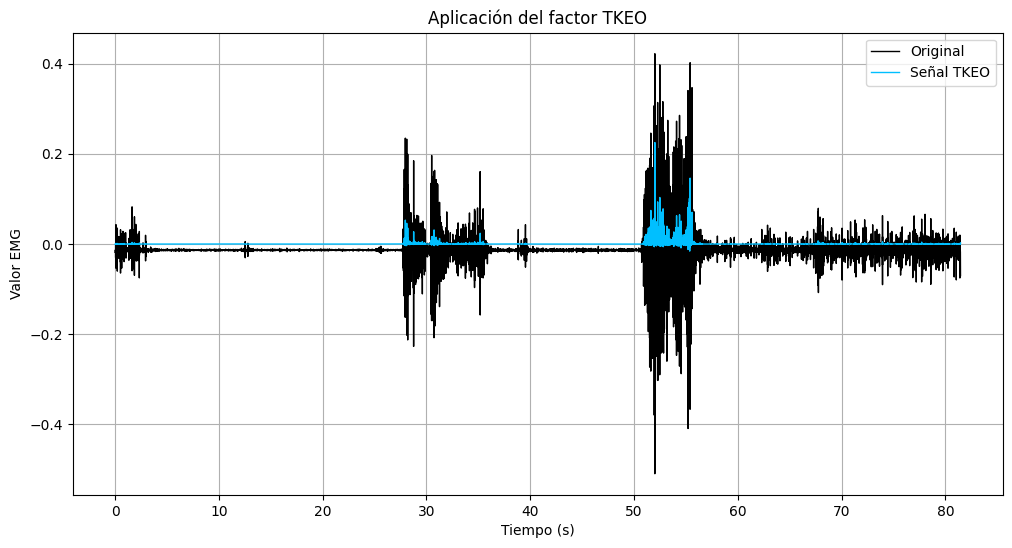

In [58]:
# [Application of TKEO Operator]
tkeo = []
for i in range(0, len(pre_pro_signal)):
    if i == 0 or i == len(pre_pro_signal) - 1:
        tkeo.append(pre_pro_signal[i])
    else:
        tkeo.append(power(pre_pro_signal[i], 2) - (pre_pro_signal[i + 1] * pre_pro_signal[i - 1]))
# Plotear la señal y los umbrales
plt.figure(figsize=(12, 6))
plt.plot(time, signal, lw=1, color='black', label='Original')
plt.plot(time, tkeo, lw=1, color='deepskyblue', label='Señal TKEO')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor EMG')
plt.title('Aplicación del factor TKEO')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Smoothing level [Size of sliding window used during the moving average process (a function of sampling frequency)]
smoothing_level_perc = 20 # Percentage.
smoothing_level = int((smoothing_level_perc / 100) * sr)

In [59]:
# [Signal Rectification]
rect_signal = absolute(tkeo)
# [First Moving Average Filter]
rect_signal = bsnb.aux_functions._moving_average(rect_signal, sr / 10)
# [Second Smoothing Phase]
smooth_signal = []
for i in range(0, len(rect_signal)):
    if smoothing_level < i < len(rect_signal) - smoothing_level:
        smooth_signal.append(mean(rect_signal[i - smoothing_level:i + smoothing_level]))
    else:
        smooth_signal.append(0)
# Plotear la señal y los umbrales
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1).get_xticklabels(), visible=False
plt.plot(time, tkeo, lw=1, color='black', label='TKEO')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor EMG')
plt.legend()
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(time, smooth_signal, lw=1, color='deepskyblue', label='Señal Smoothed')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor EMG')
plt.legend()
plt.grid(True)
plt.show()

SyntaxError: cannot assign to function call (3123226215.py, line 14)

In [33]:
# [Threshold]
avg_pre_pro_signal = average(pre_pro_signal)
std_pre_pro_signal = std(pre_pro_signal)

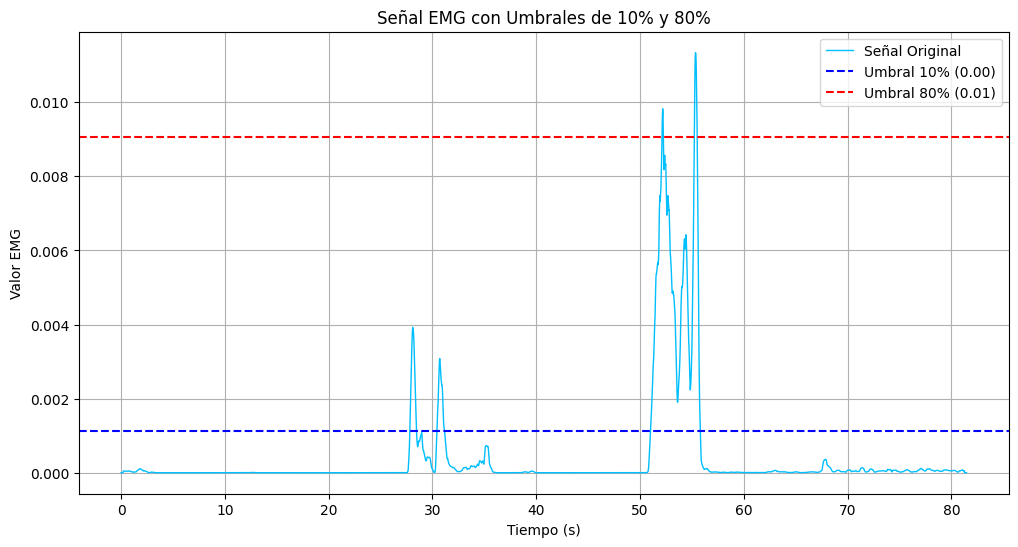

In [42]:
# Regression function.
def normReg(thresholdLevel):
    threshold_0_perc_level = (- avg_pre_pro_signal) / float(std_pre_pro_signal)
    threshold_100_perc_level = (max(smooth_signal) - avg_pre_pro_signal) / float(std_pre_pro_signal)
    m, b = linregress([0, 100], [threshold_0_perc_level, threshold_100_perc_level])[:2]
    return m * thresholdLevel + b 
    
# Chosen Threshold Level (Example with two extreme values)
threshold_level = 10 # % Relative to the average value of the smoothed signal
threshold_level_norm_10 = normReg(threshold_level)

threshold_level = 80 # % Relative to the average value of the smoothed signal
threshold_level_norm_80 = normReg(threshold_level)

threshold_10 = avg_pre_pro_signal + threshold_level_norm_10 * std_pre_pro_signal
threshold_80 = avg_pre_pro_signal + threshold_level_norm_80 * std_pre_pro_signal

# Plotear la señal y los umbrales
plt.figure(figsize=(12, 6))
plt.plot(time, smooth_signal, lw=1, color='deepskyblue', label='Señal Original')
plt.axhline(y=threshold_10, color='blue', linestyle='--', label=f'Umbral 10% ({threshold_10:.2f})')
plt.axhline(y=threshold_80, color='red', linestyle='--', label=f'Umbral 80% ({threshold_80:.2f})')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor EMG')
plt.title('Señal EMG con Umbrales de 10% y 80%')
plt.legend()
plt.grid(True)
plt.show()

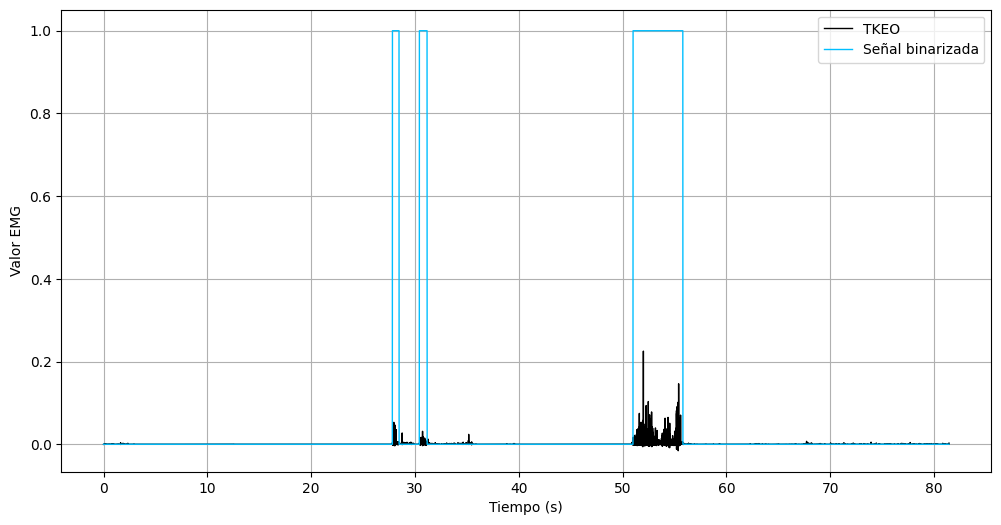

In [56]:
# Generation of a square wave reflecting the activation and inactivation periods.
binary_signal = []
for i in range(0, len(time)):
    if smooth_signal[i] >= threshold_10:
        binary_signal.append(1)
    else:
        binary_signal.append(0)
# Plotear la señal y los umbrales
plt.figure(figsize=(12, 6))
plt.plot(time, tkeo, lw=1, color='black', label='TKEO')
plt.plot(time, binary_signal, lw=1, color='deepskyblue', label='Señal binarizada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor EMG')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
diff_signal = diff(binary_signal)
act_begin = where(diff_signal == 1)[0]
act_end = where(diff_signal == -1)[0]

In [37]:
activation_data = bsnb.detect_emg_activations(signal, sr, smooth_level=20, threshold_level=10, time_units=True, volts=False, resolution=None, device=device, plot_result=True)
